In [1]:
# user defined functions
import odor_statistics_lib as osm

# dataframes
import pandas as pd
import h5py

#suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.TimeSeries = pd.Series 

#math
import numpy as np
import math
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import signal
from scipy import stats
import scipy.stats as st
from scipy.stats import kurtosis

#classification
# from sklearn.model_selection import train_test_split
# from sklearn.naive_bayes import GaussianNB
# from sklearn import metrics
# from sklearn.metrics import confusion_matrix
# from sklearn.decomposition import PCA
# from sklearn.gaussian_process import GaussianProcessClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.gaussian_process.kernels import RBF
# from sklearn.svm import SVC
# from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression


#plots
import string
import figurefirst
from figurefirst import FigureLayout,mpl_functions
import matplotlib.ticker as mtick
import pylab as plt
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar
import seaborn as sns
# from sklearn.inspection import DecisionBoundaryDisplay
from matplotlib.colors import ListedColormap
sns.set_style("whitegrid")
pd.options.mode.chained_assignment = None

In [2]:
import pingouin as pg

In [3]:
dir = '~/Documents/Myfiles/DataAnalysis/data/Sprints/HighRes/'

## Classify

In [4]:
def create_class_column_forest(dataframe):
    dataframe.loc[dataframe.avg_dist_from_source < 5, 'type'] = 0
    dataframe.loc[(dataframe.avg_dist_from_source >= 5)  & (dataframe.avg_dist_from_source < 10), 'type'] = 1
    dataframe.loc[dataframe.avg_dist_from_source >= 10, 'type'] = 2
    return dataframe

def create_class_column(dataframe):
    dataframe.loc[dataframe.avg_dist_from_source < 5, 'type'] = 0
    dataframe.loc[(dataframe.avg_dist_from_source >= 5)  & (dataframe.avg_dist_from_source < 10), 'type'] = 1
    dataframe.loc[(dataframe.avg_dist_from_source >= 10)  & (dataframe.avg_dist_from_source < 20), 'type'] = 2
    dataframe.loc[(dataframe.avg_dist_from_source >= 20)  & (dataframe.avg_dist_from_source < 30), 'type'] = 3
    dataframe.loc[dataframe.avg_dist_from_source >= 30, 'type'] = 4
    return dataframe

def create_class_column_fullts(dataframe):
    dataframe.loc[dataframe.distance_from_source < 5, 'type'] = 0
    dataframe.loc[(dataframe.distance_from_source >= 5)  & (dataframe.distance_from_source < 30), 'type'] = 1
    dataframe.loc[dataframe.distance_from_source >= 30, 'type'] = 2
    return dataframe

def create_class_column_log(dataframe):
    dataframe.loc[dataframe.log_avg_dist_from_source_signed < 0.7, 'type'] = 0
    dataframe.loc[(dataframe.log_avg_dist_from_source_signed >= 0.7)  & 
                  (dataframe.log_avg_dist_from_source_signed < 1.5), 'type'] = 1
    dataframe.loc[dataframe.log_avg_dist_from_source_signed >= 1.5, 'type'] = 2
    return dataframe

def check_length(dataframe, Nrows, nrows,N):
    if (len(Nrows) !=N):
        rowsneeded  = N - len(Nrows) 
        Nrows = Nrows.append(dataframe[(nrows.index-rowsneeded).values[0]:(nrows.index).values[0]])
        Nrows = Nrows.sort_index()
        return Nrows
    else:
        return Nrows
    
def get_rows(dataframe, N):
    nrows = dataframe.sample(1)
    Nrows = dataframe[(nrows.index).values[0]:(nrows.index+N).values[0]]
    newrows = check_length(dataframe,Nrows, nrows, N)
    return newrows

# for each collection of data to use for the classifier, get statistics from N encounters
def get_N_consecutive_encounter_stats(dataframe, distance_class, N):
    df_q = dataframe.query('type == ' + str(distance_class))   
    df_q.reset_index(inplace=True, drop=True)     
    Nrows = get_rows(df_q,N)
    
    return np.ravel( Nrows[['mean_concentration','mean_ef','log_whiff','mean_ma']].values )


# for each collection of data to use for the classifier, get statistics from N encounters
def get_N_random_encounter_stats(dataframe, distance_class,N):
    df_q = dataframe.query('type == ' + str(distance_class))   
    df_q.reset_index(inplace=True, drop=True)     
    Nrows = df_q.sample(N)
    avg_dist = np.mean(Nrows.avg_dist_from_source)
    return np.ravel( Nrows[['mean_concentration','mean_ef','log_whiff','mean_ma']].values ),avg_dist

def gather_stat_random(dataframe, distance_class, number_of_encounters,X,y,D):
    for i in range(500):
        xx,dx=get_N_random_encounter_stats(dataframe, distance_class, number_of_encounters)
        X.append(xx)
        D.append(dx)
        y.append(distance_class)
    return X,y,D

def gather_stat_consecutive(dataframe, distance_class, number_of_encounters,X,y):
    for i in range(2000):
        X.append(get_N_consecutive_encounter_stats(dataframe, distance_class, number_of_encounters))
        y.append(distance_class)
    return X,y

def stack_arrays(a):
    A = np.full((len(a), max(map(len, a))), np.nan)
    for i, aa in enumerate(a):
        A[i, :len(aa)] = aa
    return A

# def class_population_accuracy(ytest,y_pred):
    
#     cm = confusion_matrix(ytest, y_pred)
#     return ((cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]).diagonal())

def class_population_accuracy(ytest,y_pred):
    cm = confusion_matrix(ytest, y_pred)
    class_acc=[]
    # Calculate the accuracy for each one of our classes
    for idx, cls in enumerate([0,1,2]):
        # True negatives are all the samples that are not our current GT class (not the current row) 
        # and were not predicted as the current class (not the current column)
        tn = np.sum(np.delete(np.delete(cm, idx, axis=0), idx, axis=1))
        # True positives are all the samples of our current GT class that were predicted as such
        tp = cm[idx, idx]
        # The accuracy for the current class is ratio between correct predictions to all predictions
        class_acc.append((tp+tn)/np.sum(cm))
    return (class_acc)

In [5]:
def run_pca(feature_arr):
    dataframe = pd.DataFrame(index=range(len(feature_arr)),columns=range(len(feature_arr[0])))
    for i in range(len(feature_arr)):
        dataframe.iloc[i]=feature_arr[i]
        
    x=dataframe.loc[:,dataframe.columns.values].values
    
    x = StandardScaler().fit_transform(x)
    
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    return principalComponents

def box_cox_transform(dataframe):
    fitted_ef, fitted_lambda1 = stats.boxcox(dataframe.mean_ef)
    dataframe.mean_ma=dataframe.mean_ma+0.1
    fitted_ma, fitted_lambda2 = stats.boxcox(dataframe.mean_ma)
    fitted_wd, fitted_lambda3 = stats.boxcox(dataframe.length_of_encounter)
    fitted_mc, fitted_lambda3 = stats.boxcox(dataframe.mean_concentration)
    dataframe.std_whiff=dataframe.std_whiff+0.1
    fitted_sw, fitted_lambda3 = stats.boxcox(dataframe.std_whiff)
    dataframe['mean_ef']=fitted_ef
    dataframe['mean_ma']=fitted_ma
    dataframe['log_whiff']=fitted_wd
    dataframe['std_whiff']=fitted_mc
    dataframe['mean_concentration']=fitted_sw
    
def remove_motion_effect(dataframe):
    whiff_frequency=smf.ols(formula='mean_ef ~ (avg_perpendicular_encounter) + (avg_parallel_encounter)', data=dataframe).fit()
    whiff_duration=smf.ols(formula='log_whiff~ (avg_perpendicular_encounter) + (avg_parallel_encounter)', data=dataframe).fit()
    moving_avg = smf.ols(formula='whiff_ma ~ (avg_perpendicular_encounter) + (avg_parallel_encounter)', data=dataframe).fit()
    mc = smf.ols(formula='mean_concentration ~ (avg_perpendicular_encounter) + (avg_parallel_encounter)', data=dataframe).fit()
    sw = smf.ols(formula='std_whiff ~ (avg_perpendicular_encounter) + (avg_parallel_encounter)', data=dataframe).fit()
    
    dataframe['log_whiff_resid']=whiff_duration.resid
    dataframe['mean_ef_resid'] = whiff_frequency.resid
    dataframe['whiff_ma_resid'] = moving_avg.resid
    dataframe['mean_concentration_resid'] = mc.resid
    dataframe['std_whiff_resid'] = sw.resid

#     dataframe['log_whiff']=whiff_duration.resid
#     dataframe['mean_ef'] = whiff_frequency.resid
#     dataframe['whiff_ma'] = moving_avg.resid
#     dataframe['mean_concentration'] = mc.resid
#     dataframe['std_whiff'] = sw.resid

In [6]:
def get_timed_rows(dataframe,duration_of_encounters):
    x = dataframe.sample(1)
    A = x.mean_time.values.round(0) - duration_of_encounters
    B = x.mean_time.values.round(0)
    timed_rows = dataframe.loc[(dataframe.mean_time > A[0]) & (dataframe.mean_time < B[0])]
    return timed_rows
    
    
def get_timed_encounter_stats(dataframe, distance_class, duration_of_encounters):
    df_q = dataframe.query('type == ' + str(distance_class))   
    df_q.reset_index(inplace=True, drop=True)     
    
    Nrows = get_timed_rows(df_q,duration_of_encounters)
    avg_dist = np.mean(Nrows.avg_dist_from_source)
#     para = np.mean(Nrows.avg_parallel_encounter)
#     perp = np.mean(Nrows.avg_perpendicular_encounter)
    sp=np.mean(Nrows.speed_at_encounter)
    mean_time_whiff=np.mean(Nrows.mean_time)
    pack_data=np.vstack([Nrows.mean_concentration,Nrows.mean_ef,Nrows.log_whiff,Nrows.whiff_ma,Nrows.std_whiff])
    return pack_data,avg_dist,len(Nrows),mean_time_whiff,sp

def gather_stat_timed(dataframe, distance_class, duration_of_encounters,X,y,D,N,T,SP):
    for i in range(500):
        xx,dx,n,t,sp=get_timed_encounter_stats(dataframe,
                                               distance_class, duration_of_encounters)
        X.append(xx)
        D.append(dx)
        y.append(distance_class)
        N.append(n)
        T.append(t)
        SP.append(sp)
#         PL.append(par)
#         PR.append(per)
    return X,y,D,N,T,SP

In [7]:
df_windy=create_class_column_fullts(pd.read_hdf(dir+'Windy/WindyMASigned.h5'))
df_notwindy=create_class_column_fullts(pd.read_hdf(dir+'NotWindy/NotWindyMASigned.h5'))
df_forest=create_class_column_fullts(pd.read_hdf(dir+'Forest/ForestMASigned.h5'))

fdf_windy = pd.read_hdf(dir+'Windy/WindyStatsTime_std.h5')
fdf_notwindy = pd.read_hdf(dir+'NotWindy/NotWindyStatsTime_std.h5')
fdf_forest = pd.read_hdf(dir+'Forest/ForestStatsTime_std.h5')

In [278]:
# box_cox_transform(fdf_windy)
# box_cox_transform(fdf_notwindy)
# box_cox_transform(fdf_forest)

remove_motion_effect(fdf_windy)
remove_motion_effect(fdf_notwindy)
remove_motion_effect(fdf_forest)

# fdf_windy.to_hdf(dir+'Windy/WindyStatsTime.h5', key='fdf_windy', mode='w')
# fdf_notwindy.to_hdf(dir+'NotWindy/NotWindyStatsTime.h5', key='fdf_notwindy', mode='w')
# fdf_forest.to_hdf(dir+'Forest/ForestStatsTime.h5', key='fdf_forest', mode='w')

In [8]:
# a=np.where(fdf_forest.avg_perpendicular_encounter>=0)
# a_=np.where(fdf_forest.avg_perpendicular_encounter<0)
# b=np.where(fdf_forest.avg_parallel_encounter>=0)
# b_=np.where(fdf_forest.avg_parallel_encounter<0)

# a_=np.where(fdf_windy.speed_at_encounter>=1)
# a=np.where(fdf_windy.speed_at_encounter<1)
# b=np.where(fdf_forest.avg_parallel_encounter>=0)
# b_=np.where(fdf_forest.avg_parallel_encounter<0)

### Get Overall Accuracy



In [9]:
number_of_encounters = 10

desert = pd.concat([fdf_notwindy,fdf_windy])
desert.reset_index(inplace=True, drop=True)
trainset= desert
testset = fdf_forest


D_train=[]
D_test=[]
mean_time_train=[]
mean_time_test=[]
Xtest = []
ytest = []
Xtrain = []
ytrain = []
Nrows_train = []
Nrows_test = []
SP=[]
# MCTest=[]
# MCTrain=[]

for distance_class in [0,1,2]:
    Xtrain, ytrain, D_train,Nrows_train,mean_time_train,SP = gather_stat_timed(trainset,distance_class,
                      number_of_encounters, Xtrain,ytrain,D_train,Nrows_train,mean_time_train,SP)


# for distance_class in [0,1]:
#     Xtest,ytest,D_test,Nrows_test,mean_time_test = gather_stat_timed(testset,distance_class,
#                       number_of_encounters, Xtest,ytest,D_test,Nrows_test,
#                       mean_time_test)    
    

## Linear Distance Analysis - OLS

### Calculate statistics of timed train and test data

In [10]:
def calc_val(X):
    return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),kurtosis(X)])
#     return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),np.median(X),stats.mode(X[0])[0][0]])
column_names=['mc_min','mc_max','mc_mean','mc_std_dev','mc_k',
             'wf_min','wf_max','wf_mean','wf_std_dev','wf_k',
             'wd_min','wd_max','wd_mean','wd_std_dev','wd_k',
             'ma_min','ma_max','ma_mean','ma_std_dev','ma_k',
             'st_min','st_max','st_mean','st_std_dev','st_k']

## Done separately because Forest dataset has two classes
## Training set
traindf=pd.DataFrame(columns = column_names)
c1=[]
for i in range(len(Xtrain)):
    if(np.size(Xtrain[i])==0):
        c1.append(i)
        continue
    else:
        X=[]
        for j in range(len(Xtrain[i])):
            X.append(calc_val(Xtrain[i][j]))
        traindf.loc[i]=np.ravel(X)

## Test set
# testdf=pd.DataFrame(columns = column_names)
# c2=[]
# for i in range(len(Xtest)):
#     if(np.size(Xtest[i])==0):
#         c2.append(i)
#         continue
#     else:
#         Y=[]
#         for j in range(len(Xtest[i])):
#             Y.append(calc_val(Xtest[i][j]))
#         testdf.loc[i]=np.ravel(Y)

<ipython-input-10-475d987425d9>:2: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),kurtosis(X)])


In [11]:
traindf['distance']=np.delete(D_train, c1)
traindf['mean_whiff_time'] = np.delete(mean_time_train, c1)
traindf['nwhiffs'] = np.delete(Nrows_train, c1)
traindf['speed']=np.delete(SP, c1)
# traindf['mean_concentration_continuous'] = np.delete(MCTrain, c1)


# testdf['distance']=np.delete(D_test,c2)
# testdf['mean_whiff_time'] = np.delete(mean_time_test, c2)
# testdf['nwhiffs'] = np.delete(Nrows_test, c2)
# testdf['mean_concentration_continuous'] = np.delete(MCTest, c2)

In [ ]:
a=np.where(traindf.speed>=1)
a_=np.where(traindf.speed<1)
# b=np.where(traindf.parallel>=0)
# b_=np.where(traindf.parallel<0)

# traindf['parallel']=np.delete(PR, c1)
# traindf['perpendicular']=np.delete(PL, c1)


In [ ]:
f,(ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
dataframe= traindf
test_var = traindf.wd_max
ax1.grid(False)
ax2.grid(False)
var1=ax1.scatter(dataframe.distance.iloc[a],test_var.iloc[a], 
                 c =dataframe.speed.iloc[a],cmap='inferno')
var2=ax2.scatter(dataframe.distance.iloc[a_],test_var.iloc[a_],
                 c =dataframe.speed.iloc[a_], cmap='inferno')

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.08)
cbar=f.colorbar(var1, cax=cax, orientation = 'vertical')
cbar.solids.set(alpha=1) 

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.08)
cbar=f.colorbar(var2, cax=cax, orientation = 'vertical')
cbar.solids.set(alpha=1)
cbar.ax.set_ylabel('Agent Speed', c='blue',rotation=-90, labelpad=15)

ax1.set_ylabel('Whiff Duration Max')
ax1.set_xticklabels('')
ax1.set_title('Agent Speed >= 1m/s')
ax2.set_title('Agent Speed < 1m/s')
ax2.set_xlabel('Avg Distance from source')


f.tight_layout(pad=1)
figurefirst.mpl_functions.set_fontsize(f, 16)
f.savefig('../../Figure/wd_max.jpeg', dpi=300, bbox_inches = "tight")

In [ ]:
f,(ax1,ax2)=plt.subplots(1,2,figsize=(8,4))

dataframe=fdf_windy
test_var =fdf_windy.log_whiff

var1=ax1.scatter(dataframe.avg_dist_from_source.iloc[a],test_var.iloc[a], 
                 c =dataframe.speed_at_encounter.iloc[a],cmap='inferno')
var2=ax2.scatter(dataframe.avg_dist_from_source.iloc[a_],test_var.iloc[a_],
                 c =dataframe.speed_at_encounter.iloc[a_], cmap='inferno')

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.08)
cbar=f.colorbar(var1, cax=cax, orientation = 'vertical')
cbar.solids.set(alpha=1) 
# cbar.ax.set_ylabel('Distance From source', rotation=-90, labelpad=15)

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.08)
cbar=f.colorbar(var2, cax=cax, orientation = 'vertical')
cbar.solids.set(alpha=1)
cbar.ax.set_ylabel('Agent Speed', rotation=-90, labelpad=15)

ax1.set_xlabel('Avg Distance from source')
ax1.set_ylabel('Log Whiff Duration')
# ax2.set_xlabel('Agent Speed >= 1m/s')
ax1.grid(False)
ax2.grid(False)
ax2.set_yticklabels(' ')

f.tight_layout(pad=1)
figurefirst.mpl_functions.set_fontsize(f, 16)
# f.savefig('../../Figure/lwd.jpeg', dpi=300, bbox_inches = "tight")

In [ ]:
# f,ax=plt.subplots(2,2,figsize=(10,10))
# test_var=traindf.wf_std_dev
# ax[0][0].scatter(traindf.perpendicular.iloc[a],test_var.iloc[a],c=traindf.distance.iloc[a])
# var1 = ax[0][1].scatter(traindf.perpendicular.iloc[a_],test_var.iloc[a_],c=traindf.distance.iloc[a_])
# ax[1][0].scatter(traindf.parallel.iloc[b],test_var.iloc[b],c=traindf.distance.iloc[b])
# ax[1][1].scatter(traindf.parallel.iloc[b_],test_var.iloc[b_],c=traindf.distance.iloc[b_])

# ax[0][0].set_xlabel('Perpendicular Positive')
# ax[0][0].set_ylabel('WF Std Dev')
# ax[0][1].set_xlabel('Perpendicular Negative')

# ax[1][0].set_xlabel('Parallel Positive')
# ax[1][1].set_xlabel('Parallel Negative')

# divider = make_axes_locatable(ax[0][1])
# cax = divider.append_axes('right', size='5%', pad=0.08)
# cbar=f.colorbar(var1, cax=cax, orientation = 'vertical')
# cbar.solids.set(alpha=1)
# # cbar.ax.set_yticklabels(['-33', '12'])
# cbar.ax.set_ylabel('Distance From source', rotation=-90, labelpad=15)

# for i in range(2):
#     for j in range(2):
#         ax[i][j].grid(False)
        
# f.tight_layout(pad=1)
# figurefirst.mpl_functions.set_fontsize(f, 16)
# f.savefig('../../Figure/wf_std_dev.jpeg', dpi=300, bbox_inches = "tight")

In [235]:
# traindf.to_hdf(dir+'TrainDf_.h5', key='traindf', mode='w')
# testdf.to_hdf(dir+'TestDf_.h5', key='testdf', mode='w')

In [236]:
# traindf = pd.read_hdf(dir+'TrainDf.h5')
# testdf = pd.read_hdf(dir+'TestDf.h5')

In [237]:
# scaler = MinMaxScaler().fit(traindf[traindf.columns])
# traindf[traindf.columns]=scaler.transform(traindf[traindf.columns])
# testdf[testdf.columns]=scaler.transform(testdf[testdf.columns])

In [215]:
distance=smf.ols(formula=""" distance ~ mc_min+mc_max+mc_mean+mc_std_dev+mc_k+
wf_min+wf_max+wf_mean+wf_std_dev+wf_k+ wd_min+wd_max+wd_mean+wd_std_dev+wd_k+
ma_min+ma_max+ma_mean+ma_std_dev+ma_k+ st_min+st_max+st_mean+st_std_dev+st_k""", data=traindf).fit()

print(distance.rsquared)
# print(distance.summary())
# plt.rc('figure', figsize=(12, 7))

# plt.text(0.01, 0.05, str(distance.summary()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
# plt.axis('off')
# plt.tight_layout()
# plt.savefig('../../Figure/olsresultsdesert.jpeg', dpi=300, bbox_inches = "tight")


0.687175431998786


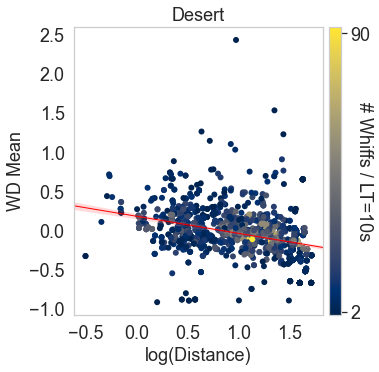

In [30]:
f, (ax) = plt.subplots(1,1, figsize=(5,5))
dataframe=traindf
distance = np.log10(dataframe.distance)
test_var=(dataframe.wd_mean)

var1 = ax.scatter(distance,test_var, 
                   c=dataframe.nwhiffs,cmap='cividis', 
            edgecolors='none')
ax.grid(False)
# ax1.set_ylim(4.5,)
ax.set_title('Desert')
g1 = sns.regplot(x=distance,y=(test_var) , data=dataframe,
            ax=ax, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)

ax.set_xlabel('log(Distance)')
ax.set_ylabel('WD Mean')

# mpl_functions.adjust_spines(ax,['left','bottom'],spine_locations={}, 
#                                 smart_bounds=True,yticks=[5,10],
#                                 xticks=[-0.5,0.8,2.0],
#                                 linewidth=1)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.08)
cbar=f.colorbar(var1, cax=cax, orientation = 'vertical',ticks=[2,90])
cbar.solids.set(alpha=1)
# cbar.ax.set_yticklabels(['-33', '12'])
cbar.ax.set_ylabel('# Whiffs / LT=10s', rotation=-90, labelpad=2)


f.tight_layout(pad=1)
figurefirst.mpl_functions.set_fontsize(f, 18)
# f.savefig('../../Figure/mc_mean.jpeg', dpi=300, bbox_inches = "tight")



In [29]:
check_relation=smf.ols(formula=""" wf_mean ~ wd_mean""", data=traindf).fit()
print(check_relation.summary())

                            OLS Regression Results                            
Dep. Variable:                wf_mean   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     6.729
Date:                Wed, 17 Aug 2022   Prob (F-statistic):            0.00958
Time:                        17:32:20   Log-Likelihood:                -1729.2
No. Observations:                1404   AIC:                             3462.
Df Residuals:                    1402   BIC:                             3473.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3439      0.022    -15.355      0.0

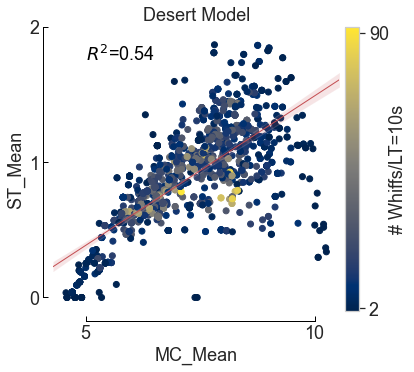

In [109]:
f,ax=plt.subplots(1,1,figsize=(5.5,5))
ax.grid(False)
var=ax.scatter(traindf.mc_mean,traindf.st_mean, c=traindf.nwhiffs,cmap='cividis')
ax.set_title('Desert Model')
g1 = sns.regplot(x=traindf.mc_mean,y=traindf.st_mean , data=traindf,
            ax=ax, line_kws={'color':'r','linewidth':1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)
ax.set_ylim(-0.1,2.0)
mpl_functions.adjust_spines(ax,['left','bottom'],spine_locations={}, 
                                smart_bounds=True,
                                xticks=[5,10],
                                yticks=[0,1,2],
                                linewidth=1)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.08)
cbar=f.colorbar(var, cax=cax, orientation = 'vertical',ticks=[2,90])
cbar.solids.set(alpha=1)
cbar.ax.set_ylabel('# Whiffs/LT=10s', rotation=90,labelpad=0)
ax.set_xlabel('MC_Mean')
ax.set_ylabel('ST_Mean')
ax.text(5,1.75,'$R^2$=0.54', c='black')
f.tight_layout(pad=1)
figurefirst.mpl_functions.set_fontsize(f, 18)
f.savefig('../../Figure/mc_st.jpeg', dpi=300, bbox_inches = "tight")

In [22]:
# traindf.to_hdf(dir+'NormalityTrainBC.h5', key='traindf', mode='w')
# testdf.to_hdf(dir+'NormalityTestBC.h5', key='traindf', mode='w')

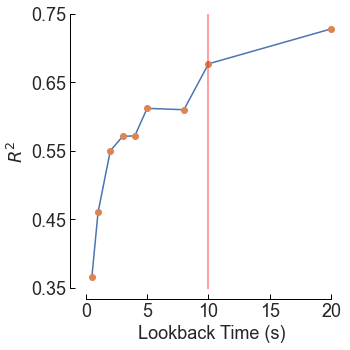

In [85]:
f,ax = plt.subplots(1,1,figsize=(5,5))
ax.plot([0.5,1,2,3,4,5,8,10,20],[0.366,0.46,0.55,0.571,0.572,0.612,0.61,0.677,0.728])
ax.plot([0.5,1,2,3,4,5,8,10,20],[0.366,0.46,0.55,0.571,0.572,0.612,0.61,0.677,0.728],'o')
ax.grid(False)

ax.set_xlabel('Lookback Time (s)')
ax.set_ylabel('$R^2$')
ax.axvline(10, c='red', alpha=0.5)
# ax.set_xlim(0,)
mpl_functions.adjust_spines(ax,['left','bottom'],spine_locations={}, 
                                smart_bounds=True,
                                xticks=[0,5,10,15,20],
                                yticks=[0.35,0.45,0.55,0.65,0.75],
                                linewidth=1)
figurefirst.mpl_functions.set_fontsize(f, 18)
f.tight_layout(pad=1)
plt.show()
f.savefig('../../Figure/Rsquarelookback.jpeg', dpi=300, bbox_inches = "tight")

In [207]:
def wrapped_angular_diff(a, b):
    return (np.arctan2(np.sin(a-b), np.cos(a-b)))

def wrap_angle(dataframe):
    diff=[]
    for i in range(0,len(dataframe)):
        if i == 0:
            diff.append(0)
        else:
            diff.append(wrapped_angular_diff(dataframe.D[i-1],dataframe.D[i]))
            
    return diff

df_windy['angle_difference']=wrap_angle(df_windy)
df_notwindy['angle_difference']=wrap_angle(df_notwindy)
df_forest['angle_difference']=wrap_angle(df_forest)


In [208]:
def cal_ti_dir(dataframe):
    sd = st.circstd(dataframe.angle_difference,high = np.pi,low = -np.pi)
#     m = np.mean(dataframe.angle_difference)
    return sd
    
ti_windy=cal_ti_dir(df_windy)
ti_notwindy=cal_ti_dir(df_notwindy)
ti_forest=cal_ti_dir(df_forest)

# def cal_ti_vel(dataframe):
#     sd = np.std([[dataframe.corrected_u],[dataframe.corrected_v]])
#     m= np.mean(np.sqrt(np.square(dataframe.corrected_u)+np.square(dataframe.corrected_v)))
#     return sd/m
    
# ti_windy=cal_ti_vel(df_windy)
# ti_notwindy=cal_ti_vel(df_notwindy)
# ti_forest=cal_ti_vel(df_forest)

In [270]:
st.circstd(df_notwindy.D,high = 2*np.pi,low = 0)

3.631559965608572

In [209]:
print(ti_windy,ti_notwindy,ti_forest)

0.1807293313268987 0.5551641198068803 0.5653493183419588


In [244]:
distance=smf.ols(formula=""" distance ~ mc_mean + wf_std_dev + wd_min+ ma_max""", data=traindf).fit()
print(distance.summary())

                            OLS Regression Results                            
Dep. Variable:               distance   R-squared:                       0.226
Model:                            OLS   Adj. R-squared:                  0.223
Method:                 Least Squares   F-statistic:                     68.46
Date:                Tue, 23 Aug 2022   Prob (F-statistic):           7.28e-51
Time:                        13:07:16   Log-Likelihood:                -2227.6
No. Observations:                 942   AIC:                             4465.
Df Residuals:                     937   BIC:                             4489.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     17.6738      0.950     18.596      0.0

In [245]:
# tidf.forest=distance.params
# tidf.parameter=tidf.index

In [229]:
# tidf=pd.DataFrame(columns=['windy','notwindy','forest','parameter'])

In [218]:
# tidf=pd.read_hdf(dir+'ti.h5')

In [250]:
# tidf.reset_index(drop=True, inplace=True)
tidf

,windy,notwindy,forest,parameter
0,109.698117,93.614271,17.673846,Intercept
1,-10.535377,-8.030763,-1.341251,mc_mean
2,6.093453,10.958171,-0.274426,wf_std_dev
3,6.267747,12.832934,0.885762,wd_min
4,-1.283640,-0.025054,-0.003681,ma_max


In [261]:
ti=[1,2,3]

In [258]:
print(ti)

[0.1807293313268987, 0.5551641198068803, 0.5653493183419588]


In [254]:
ti=[ti_windy,ti_notwindy,ti_forest]

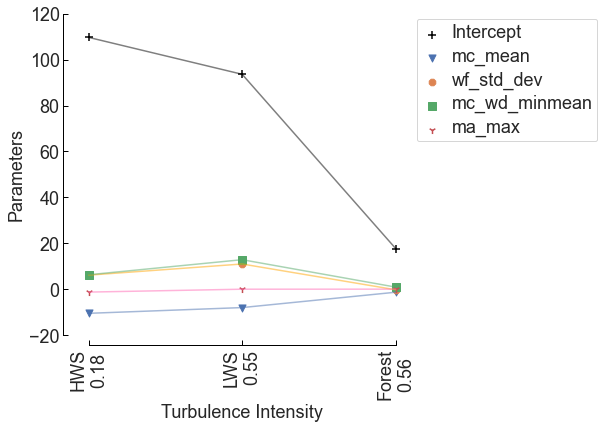

In [267]:
f,ax=plt.subplots(1,1,figsize=(6,6))
ax.grid(False)
ax.scatter(ti,tidf.iloc[0,0:3], label='Intercept', marker='+',s=50, color='black')
ax.plot(ti,tidf.iloc[0,0:3], alpha=0.5,c='black')
ax.scatter(ti,tidf.iloc[1,0:3], label='mc_mean',marker='v',s=50)
ax.plot(ti,tidf.iloc[1,0:3], alpha=0.5,c='b')
ax.scatter(ti,tidf.iloc[2,0:3], label='wf_std_dev',marker='8',s=50)
ax.plot(ti,tidf.iloc[2,0:3], alpha=0.5,c='orange')
ax.scatter(ti,tidf.iloc[3,0:3], label='wd_mean',marker='s',s=50)
ax.plot(ti,tidf.iloc[3,0:3], alpha=0.5,c='g')
ax.scatter(ti,tidf.iloc[4,0:3], label='ma_max',marker='1',s=50)
ax.plot(ti,tidf.iloc[4,0:3], alpha=0.5,c='hotpink')

mpl_functions.adjust_spines(ax,['left','bottom'],spine_locations={}, 
                                smart_bounds=True,xticks=ti,
                                linewidth=1)
ax.set_xlabel('Turbulence Intensity')
ax.set_ylabel('Parameters')
ax.set_xticklabels(['HWS\n0.18','LWS\n0.55','Forest\n0.56'])
plt.xticks(rotation=90)
# f.suptitle('Turbulence Intensity vs Environment Stats')
ax.legend(bbox_to_anchor=(1, 1))
f.tight_layout(pad=2)
figurefirst.mpl_functions.set_fontsize(f, 18)
f.savefig('../../Figure/ti_plot.jpeg', dpi=300, bbox_inches = "tight")

In [71]:
# column_names=['mc_min','mc_max','mc_mean','mc_std_dev','mc_k',
#              'wf_min','wf_max','wf_mean','wf_std_dev','wf_k',
#              'wd_min','wd_max','wd_mean','wd_std_dev','wd_k',
#              'ma_min','ma_max','ma_mean','ma_std_dev','ma_k',
#              'st_min','st_max','st_mean','st_std_dev','st_k']
# y=traindf.distance
# x=traindf.loc[traindf.distance.notnull(), column_names].values
# x = sm.add_constant(x)

# olsmod = sm.OLS(y, x)
# olsres = olsmod.fit()
# ypred = olsres.predict(x)
# print(olsres.summary())

In [ ]:
f, (ax) = plt.subplots(1,1, figsize=(5,5))
dataframe=traindf
distance = np.log10(dataframe.distance)
test_var=(dataframe.wf_mean)

var1 = ax.scatter(distance,test_var, 
                   c=dataframe.mc_mean,cmap='bone', 
            edgecolors='none')
ax.grid(False)
# ax1.set_ylim(4.5,)
ax.set_title('Desert Model')
g1 = sns.regplot(x=distance,y=(test_var) , data=dataframe,
            ax=ax, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)

ax.set_xlabel('log(Distance)')
ax.set_ylabel('WF Kurtosis')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.08)
cbar=f.colorbar(var1, cax=cax, orientation = 'vertical')
cbar.solids.set(alpha=1)
# cbar.ax.set_yticklabels(['-33', '12'])
cbar.ax.set_ylabel('MC Mean', rotation=90)


f.tight_layout(pad=1)
figurefirst.mpl_functions.set_fontsize(f, 16)
# f.savefig('../../Figure/wfk_resid.jpeg', dpi=300, bbox_inches = "tight")

### Finding significant Parameters

In [193]:
df = pd.read_hdf(dir+'Aic_R2/Forest_Rsquared_f.h5')

In [194]:
col_name=[]
for i in range(len(df.columns[:20])):
    if (df.iloc[:,i].max() >= 0.05):
        col_name.append(df.columns[i])

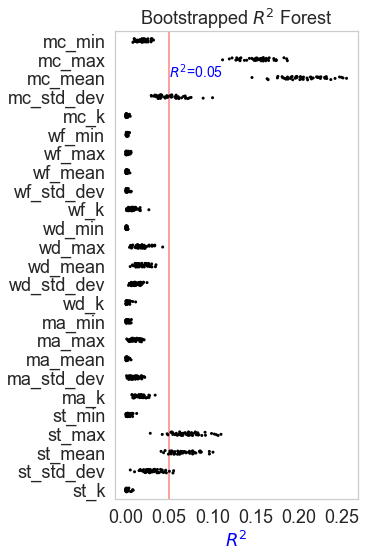

In [197]:

f,ax=plt.subplots(1,1,figsize=(5,8))
sns.stripplot(data=df, ax=ax, dodge=True,orient='h', size=3, color='Black')
ax.grid(False)
# ax.set_xticklabels(, rotation='vertical')
ax.axvline(0.05, color = 'red', alpha=0.5)
ax.set_xlabel('$R^2$',c='blue')

ax.set_title('Bootstrapped $R^2$ Forest')
f.tight_layout(pad=2)
figurefirst.mpl_functions.set_fontsize(f, 18)
ax.text(0.05,2,'$R^2$=0.05',color='black',fontsize='14',c='blue')

f.savefig('../../Figure/forestr2.jpeg', dpi=300, bbox_inches = "tight")

In [198]:
col_name

['mc_max', 'mc_mean', 'mc_std_dev']

In [199]:
import itertools
column_names=col_name
rsquaredres=[]
aicres=[]
para_list = []
pval=[]
bicres=[]

for i in range(1,len(column_names)+1):
    sub_parameter_list = list(itertools.combinations(column_names,i))
  
    for elements in sub_parameter_list:
        para_list.append(elements)
        y=traindf.distance
        x = sm.add_constant(traindf.loc[traindf.distance.notnull(), elements].values)
        olsmod = sm.OLS(y, x)
        olsres = olsmod.fit()
        rsquaredres.append(olsres.rsquared)
        aicres.append(olsres.aic)
        pval.append(olsres.f_pvalue)
        bicres.append(olsres.bic)


In [200]:
combtest=pd.DataFrame()
combtest['rsquared']=rsquaredres
combtest['aic']=aicres
combtest['parameters']=para_list
combtest['fpvalue']=pval
combtest['bic']=bicres

In [201]:
combtest['n_para']=np.zeros(len(combtest))
for i in range(len(combtest)):
    combtest.n_para[i]=len(combtest.parameters[i])

In [202]:
# combtest.iloc[combtest.aic.idxmin()].values()

In [203]:
aic_min=[]
for i in range(1,len(column_names)+1):
    aic_min.append(np.min(combtest.aic.iloc[(np.where(combtest.n_para==i))]))

aic_delta=[]
for i in range(len(aic_min)):
    if i ==0:
        aic_delta.append(0)
    else:
        aic_delta.append(aic_min[i]-aic_min[i-1])
        
aic_table=pd.DataFrame()
aic_table['aic_min'] = aic_min
aic_table['aic_delta']=aic_delta
aic_table

,aic_min,aic_delta
0,4400.734921,0.000000
1,4357.932217,-42.802704
2,4350.310178,-7.622039


In [204]:
for i in range(len(aic_table)):
    print(i)
    print(*(combtest.parameters[combtest.aic==(combtest.aic.loc[(np.where(combtest.n_para==i))]).min()]))

0

1
('mc_mean',)
2
('mc_mean', 'mc_std_dev')


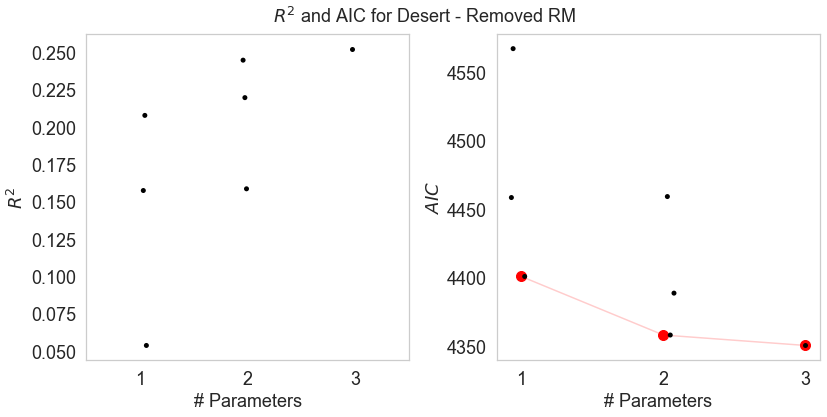

In [205]:
f,(ax,ax1)=plt.subplots(1,2,figsize=(12,6))
ax.grid(False)
ax.set_ylabel('$R^2$')
sns.stripplot(x=combtest.n_para,y=combtest.rsquared,data=combtest, 
              ax=ax, color='black',
              dodge=True, size=5)

ax.set_ylabel('$R^2$')
ax.set_xlabel('# Parameters')
ax.set_xticklabels(np.arange(1,len(aic_table)+1,1))
# ax.set_title('$R^2$')

sns.stripplot(x=combtest.n_para,y=combtest.aic, data=combtest, color='black',
              ax=ax1,dodge=True, size=5)
ax1.set_xlabel('# Parameters')
ax1.set_ylabel('$AIC$')
ax1.grid(False)
ax1.scatter(np.arange(0,len(aic_table),1),aic_min,c='red', marker='o', facecolor=None,s=100)
ax1.plot(np.arange(0,len(aic_table),1),aic_min,c='red',alpha=0.2)

ax1.set_xticklabels(np.arange(1,len(aic_table)+1,1))

f.tight_layout(pad=3)
f.suptitle('$R^2$ and AIC for Desert - Removed RM')
figurefirst.mpl_functions.set_fontsize(f, 18)
# f.savefig('../../Figure/R2_AIC_Comb_r.jpeg', dpi=300, bbox_inches = "tight")

### Mutual Information

In [12]:
model=smf.ols(formula=""" mc_mean ~ st_mean""", data=traindf).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                mc_mean   R-squared:                       0.533
Model:                            OLS   Adj. R-squared:                  0.533
Method:                 Least Squares   F-statistic:                     1611.
Date:                Thu, 01 Sep 2022   Prob (F-statistic):          1.52e-235
Time:                        09:04:02   Log-Likelihood:                -1788.0
No. Observations:                1412   AIC:                             3580.
Df Residuals:                    1410   BIC:                             3591.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.1101      0.057     89.058      0.0

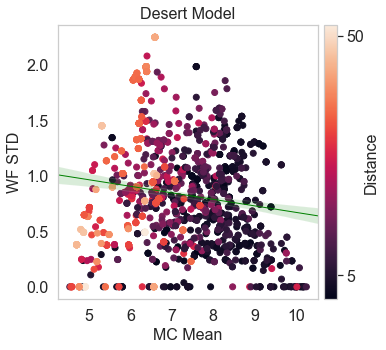

In [144]:
f,ax=plt.subplots(1,1,figsize=(5.5,5))
ax.grid(False)
dat=traindf
v1=dat.mc_mean
v2=(dat.wf_std_dev)
v3=dat.distance
var1 = ax.scatter(v1,v2, c=v3)

ax.set_title('Desert Model')
g1 = sns.regplot(x=v1,y=v2 , data=dat,
            ax=ax, line_kws={'color':'green','linewidth':1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)

ax.set_xlabel('MC Mean')
ax.set_ylabel('WF STD')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.08)
cbar=f.colorbar(var1, cax=cax, orientation = 'vertical',ticks=[5,50])
cbar.solids.set(alpha=1)
cbar.ax.set_ylabel('Distance', rotation=90, labelpad=0)
# f.suptitle('$R^2$ and AIC for Desert')
figurefirst.mpl_functions.set_fontsize(f, 16)
# ax.text(2.0,1,'$R^2=0.03',color='blue',fontsize=14)
f.tight_layout(pad=1)

# f.savefig('../../Figure/wdstd1.jpeg', dpi=300, bbox_inches = "tight")

In [13]:
from scipy import ndimage

EPS = np.finfo(float).eps
def mutual_information_2d(x, y, sigma=1, normalized=True):
    """
    Computes (normalized) mutual information between two 1D variate from a
    joint histogram.
    Parameters
    ----------
    x : 1D array
        first variable
    y : 1D array
        second variable
    sigma: float
        sigma for Gaussian smoothing of the joint histogram
    Returns
    -------
    nmi: float
        the computed similariy measure
    """
    bins = (10000, 10000)

    jh = np.histogram2d(x, y, bins=bins)[0]

    # smooth the jh with a gaussian filter of given sigma
    ndimage.gaussian_filter(jh, sigma=sigma, mode='constant',
                                 output=jh)

    # compute marginal histograms
    jh = jh + EPS
    sh = np.sum(jh)
    jh = jh / sh
    s1 = np.sum(jh, axis=0).reshape((-1, jh.shape[0]))
    s2 = np.sum(jh, axis=1).reshape((jh.shape[1], -1))

    # Normalised Mutual Information of:
    # Studholme,  jhill & jhawkes (1998).
    # "A normalized entropy measure of 3-D medical image alignment".
    # in Proc. Medical Imaging 1998, vol. 3338, San Diego, CA, pp. 132-143.
    if normalized:
        mi = ((np.sum(s1 * np.log(s1)) + np.sum(s2 * np.log(s2)))
                / np.sum(jh * np.log(jh))) - 1
    else:
        mi = ( np.sum(jh * np.log(jh)) - np.sum(s1 * np.log(s1))
               - np.sum(s2 * np.log(s2)))

    return mi

In [17]:
mi_par=['mc_min','mc_max','mc_mean','mc_std_dev','wf_max','wf_mean',
 'wf_std_dev','wd_min','wd_max','wd_mean','wd_std_dev',
 'ma_max','ma_mean','ma_std_dev','st_min','st_max','st_mean']

In [18]:
import itertools

In [86]:
mi=[]
para=[]
sub_parameter_list = list(itertools.combinations(mi_par,2))
# for i in range(len(sub_parameter_list)):
#     print(sub_parameter_list[i])
# para.append(sub_parameter_list)
# mi.append(mutual_information_2d(sub_parameter_list))

for i in range(len(sub_parameter_list)):
    para.append(sub_parameter_list[i])
    mi.append(mutual_information_2d(traindf[sub_parameter_list[i][0]],traindf[sub_parameter_list[i][1]]))

In [132]:
midf=pd.DataFrame()
midf['parameters_left']=np.array(para)[:,0]
midf['parameters_right']=np.array(para)[:,1]
midf['mi']=mi
midf['parameters']=para


In [143]:
# midf.parameters.iloc[np.where(midf.mi>0.6)]

<ipython-input-142-2af54e806b1c>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(midf.parameters_right, rotation='vertical')


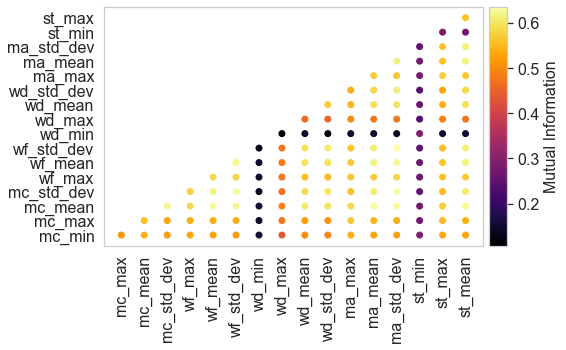

In [142]:
f,ax=plt.subplots(1,1,figsize=(8,5))

v = ax.scatter(midf.parameters_right,midf.parameters_left,c=midf.mi, cmap='inferno')
ax.set_xticklabels(midf.parameters_right, rotation='vertical')
ax.grid(False)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.08)
cbar=f.colorbar(v, cax=cax, orientation = 'vertical')
cbar.solids.set(alpha=1)
# cbar.ax.set_yticklabels(['-33', '12'])
cbar.ax.set_ylabel('Mutual Information', rotation=90, labelpad=5)
figurefirst.mpl_functions.set_fontsize(f, 16)
f.tight_layout(pad=1)
# f.savefig('../../Figure/mi.jpeg', dpi=300, bbox_inches = "tight")

In [20]:
traindf.keys()

Index(['mc_min', 'mc_max', 'mc_mean', 'mc_std_dev', 'mc_k', 'wf_min', 'wf_max',
       'wf_mean', 'wf_std_dev', 'wf_k', 'wd_min', 'wd_max', 'wd_mean',
       'wd_std_dev', 'wd_k', 'ma_min', 'ma_max', 'ma_mean', 'ma_std_dev',
       'ma_k', 'st_min', 'st_max', 'st_mean', 'st_std_dev', 'st_k', 'distance',
       'mean_whiff_time', 'nwhiffs', 'speed'],
      dtype='object')

In [19]:
# import pingouin as pg

pg.partial_corr(data=traindf, x='mc_mean', y='wf_std_dev', covar='wd_max')


,n,r,CI95%,p-val
pearson,1412,-0.194881,"[-0.24, -0.14]",1.527007e-13


### Normality

In [ ]:
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test = sms.het_breuschpagan(distance.resid, distance.model.exog)
lzip(name, test)

In [39]:
# ## Test Dataset
# Xnew = testdf.loc[testdf.distance.notnull(), column_names].values
# Xnew = sm.add_constant(Xnew) 
# ynewpred = olsres.predict(Xnew)

# traindf['predicted_distance']=ypred
# testdf['predicted_distance']=ynewpred

# #Compute Accuracy with some tolerance

# accuracy_train = {i for i in traindf.distance if np.isclose(traindf.predicted_distance, i, 0.1).any()}
# accuracy_test = {i for i in testdf.distance if np.isclose(testdf.predicted_distance, i, 0.1).any()}

# print('Accuracy Train Dataset: ',(len(accuracy_train)/len(traindf.predicted_distance)) *100 )
# print('Accuracy Test Dataset: ',(len(accuracy_test)/len(testdf.predicted_distance)) *100 )

In [83]:
err = testdf.distance-testdf.predicted_distance
len(err)

932

<ipython-input-85-b870d50b07e5>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(['-33', '12'])


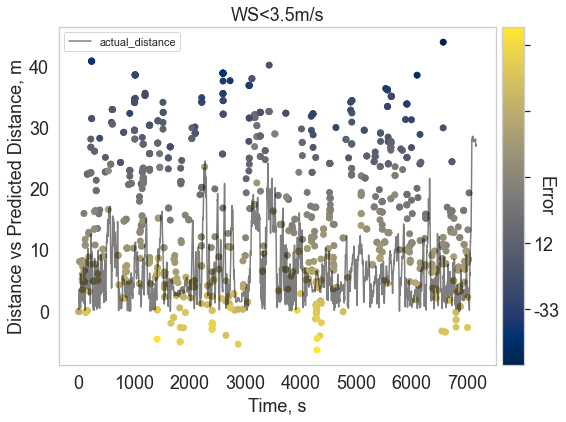

In [85]:
f ,ax=plt.subplots(figsize=(8,6))
ax.grid(False)
v = ax.scatter(testdf.mean_whiff_time,testdf.predicted_distance,c=err,
           cmap='cividis')
ax.plot(x.time,x.distance_from_source, c='black',alpha=0.5, label='actual_distance')
ax.set_xlabel('Time, s')
ax.set_ylabel('Distance vs Predicted Distance, m')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.08)
cbar=f.colorbar(v, cax=cax, orientation = 'vertical')
cbar.solids.set(alpha=1)
cbar.ax.set_yticklabels(['-33', '12'])
cbar.ax.set_ylabel('Error', rotation=-90, labelpad=-5)
ax.set_title('WS<3.5m/s')
figurefirst.mpl_functions.set_fontsize(f, 18)
ax.legend()
f.tight_layout(pad=1)
# f.savefig('../../Figure/predictedvscontinuousfores.jpeg', dpi=300, bbox_inches = "tight")

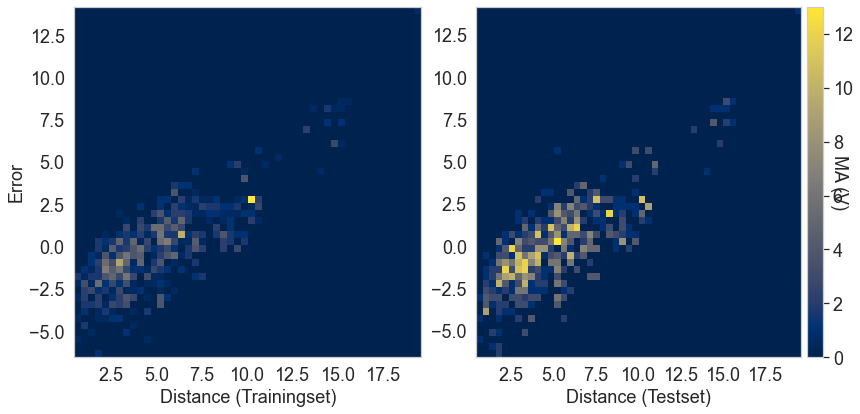

In [25]:
f, ax = plt.subplots(1,2,figsize=(12,6))
hist = ax[0].hist2d(traindf.distance, traindf.distance-traindf.predicted_distance, bins=50,cmap='cividis')
hist1 = ax[1].hist2d(testdf.distance, testdf.distance-testdf.predicted_distance, bins=50,cmap='cividis')
ax[0].set_ylabel('Error')
ax[0].set_xlabel('Distance (Trainingset)')
ax[1].set_xlabel('Distance (Testset)')

divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.08)
cbar=f.colorbar(hist1[3], cax=cax, orientation = 'vertical')
cbar.solids.set(alpha=1)
cbar.solids.set(alpha=1)
cbar.ax.set_ylabel('MA (V)', rotation=-90, labelpad=-5)
# f.colorbar(hist1[3], ax=ax[1])

f.tight_layout(pad=2)
figurefirst.mpl_functions.set_fontsize(f, 18)

f.savefig('../../Figure/Hist2d_fnf.jpeg', dpi=300, bbox_inches = "tight")

In [240]:
train_sorted=traindf.sort_values(by=['mean_whiff_time'])
test_sorted=testdf.sort_values(by=['mean_whiff_time'])
train_sorted.reset_index(inplace=True, drop=True)  
test_sorted.reset_index(inplace=True, drop=True)  

In [47]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth
T1['smoothed_prediction'] = smooth(T1.predicted_distance,30)
T2['smoothed_prediction'] = smooth(T2.predicted_distance,20)

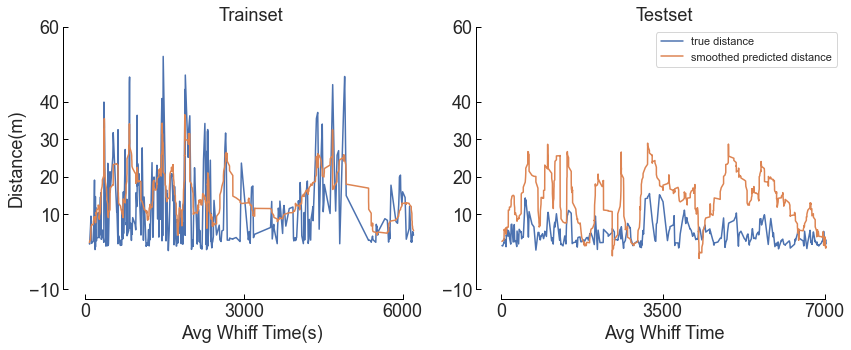

In [82]:
f, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5))

ax1.plot(T1.mean_whiff_time,T1.distance)
ax1.plot(T1.mean_whiff_time,T1.smoothed_prediction)

ax2.plot(T2.mean_whiff_time,T2.distance,label='true distance')
ax2.plot(T2.mean_whiff_time,T2.smoothed_prediction,label='smoothed predicted distance')


ax1.grid(False)
ax2.grid(False)
ax1.set_title('Trainset')
ax2.set_title('Testset')
ax1.set_xlabel('Avg Whiff Time(s)')
ax1.set_ylabel('Distance(m)')
ax2.set_xlabel('Avg Whiff Time')

# ax1.set_xlim(4000,5000)
# ax2.set_xlim(4000,5000)
mpl_functions.adjust_spines(ax1,['left','bottom'],spine_locations={}, 
                                smart_bounds=True,
                                xticks=[0,3000,6000],
                                yticks=[-10,10,20,30,40,60],
                                linewidth=1)
mpl_functions.adjust_spines(ax2,['left','bottom'],spine_locations={}, 
                                smart_bounds=True,
                                xticks=[0,3500,7000],
                                yticks=[-10,10,20,30,40,60],
                                linewidth=1)
ax2.legend()
figurefirst.mpl_functions.set_fontsize(f, 18)
ax2.legend(bbox_to_anchor=(1, 1))

f.tight_layout(pad=1)
f.savefig('../../Figure/b.jpeg', dpi=300, bbox_inches = "tight")

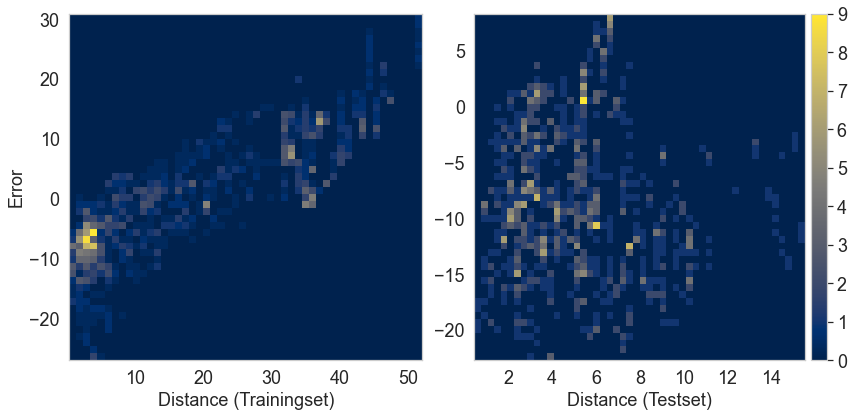

In [54]:
f, ax = plt.subplots(1,2,figsize=(12,6))
hist = ax[0].hist2d(T1.distance, T1.distance-T1.smoothed_prediction, bins=50,cmap='cividis')
hist1 = ax[1].hist2d(T2.distance, T2.distance-T2.smoothed_prediction, bins=50,cmap='cividis')
ax[0].set_ylabel('Error')
ax[0].set_xlabel('Distance (Trainingset)')
ax[1].set_xlabel('Distance (Testset)')

divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.08)
cbar=f.colorbar(hist1[3], cax=cax, orientation = 'vertical')
cbar.solids.set(alpha=1)
# f.colorbar(hist1[3], ax=ax[1])

f.tight_layout(pad=2)
figurefirst.mpl_functions.set_fontsize(f, 18)

# f.savefig('../../Figure/Hist2d_smoothed.jpeg', dpi=300, bbox_inches = "tight")

In [84]:
accuracy_train = {i for i in T1.predicted_distance if np.isclose(T1.distance, i, 0.1).any()}
accuracy_test = {i for i in T2.predicted_distance if np.isclose(T2.distance, i, 0.1).any()}

print('Accuracy Train Dataset: ',(len(accuracy_train)/len(T1.predicted_distance)) *100 )
print('Accuracy Test Dataset: ',(len(accuracy_test)/len(T2.predicted_distance)) *100 )

Accuracy Train Dataset:  44.25531914893617
Accuracy Test Dataset:  32.45521601685985


### Continuous Stats


In [ ]:
def get_timed_rows_cont(same_time_location,dataframe_cont,duration_of_encounters):
    y=dataframe_cont.iloc[same_time_location]
    A = y.time.round(0) - duration_of_encounters
    B = y.time.round(0)
    timed_rows_cont = dataframe_cont.loc[(dataframe_cont.time > A) & (dataframe_cont.time < B)]
     
    return np.mean(timed_rows_cont.odor)

def get_timed_rows(dataframe,dataframe_cont,duration_of_encounters):
    x = dataframe.sample(1)
    A = x.mean_time.values.round(0) - duration_of_encounters
    B = x.mean_time.values.round(0)

    if (np.where(dataframe_cont.time.round(0)==B[0])[0].size == 0):
        #find index of closest value in continuous data frame
        same_time_location = dataframe_cont.iloc[(dataframe_cont['time']-B[0]).abs().argsort()[:1]].index[0]     
    else:
        same_time_location = np.where(dataframe_cont.time.round(0) == B[0])[0][0]
    
    timed_rows_odor_mean = get_timed_rows_cont(same_time_location,dataframe_cont,duration_of_encounters)
    timed_rows = dataframe.loc[(dataframe.mean_time > A[0]) & (dataframe.mean_time < B[0])]
    return timed_rows,timed_rows_odor_mean
    
    
def get_timed_encounter_stats(dataframe,dataframe_cont, distance_class, duration_of_encounters):
    df_q = dataframe.query('type == ' + str(distance_class))   
    df_q.reset_index(inplace=True, drop=True)     
        
    df_q_cont = dataframe_cont.query('type == ' + str(distance_class))   
    df_q_cont.reset_index(inplace=True, drop=True)     
    
    Nrows,mean_conc = get_timed_rows(df_q,df_q_cont,duration_of_encounters)
    avg_dist = np.mean(Nrows.avg_dist_from_source)
    mean_time_whiff=np.mean(Nrows.mean_time)
#     mean_conc=np.mean(Nrows_cont.odor)
    pack_data=np.vstack([Nrows.mean_concentration,Nrows.mean_ef,Nrows.log_whiff,Nrows.whiff_ma,Nrows.std_whiff])
    return pack_data,avg_dist,len(Nrows),mean_time_whiff,mean_conc

def gather_stat_timed(dataframe,dataframe_cont, distance_class, duration_of_encounters,X,y,D,N,T,MC):
    for i in range(500):
        xx,dx,n,t,mc=get_timed_encounter_stats(dataframe, dataframe_cont,
                                               distance_class, duration_of_encounters)
        X.append(xx)
        D.append(dx)
        y.append(distance_class)
        N.append(n)
        T.append(t)
        MC.append(mc)

    return X,y,D,N,T,MC

In [ ]:
number_of_encounters = 10

desert = pd.concat([fdf_notwindy,fdf_windy])
desert.reset_index(inplace=True, drop=True)
trainset= desert 
testset = fdf_forest

desert_cont = pd.concat([df_notwindy,df_windy])
desert_cont.reset_index(inplace=True, drop=True)



D_train=[]
D_test=[]
mean_time_train=[]
mean_time_test=[]
Xtest = []
ytest = []
Xtrain = []
ytrain = []
Nrows_train = []
Nrows_test = []
MCTest=[]
MCTrain=[]

for distance_class in [0,1,2]:
    Xtrain, ytrain, D_train,Nrows_train,mean_time_train,MCTrain = gather_stat_timed(trainset,desert_cont,
                                                                                    distance_class,
                      number_of_encounters, Xtrain,ytrain,D_train,Nrows_train,
                      mean_time_train,MCTrain)


# for distance_class in [0,1]:
#     Xtest,ytest,D_test,Nrows_test,mean_time_test,MCTest = gather_stat_timed(testset,df_forest,distance_class,
#                       number_of_encounters, Xtest,ytest,D_test,Nrows_test,
#                       mean_time_test,MCTest)    
    

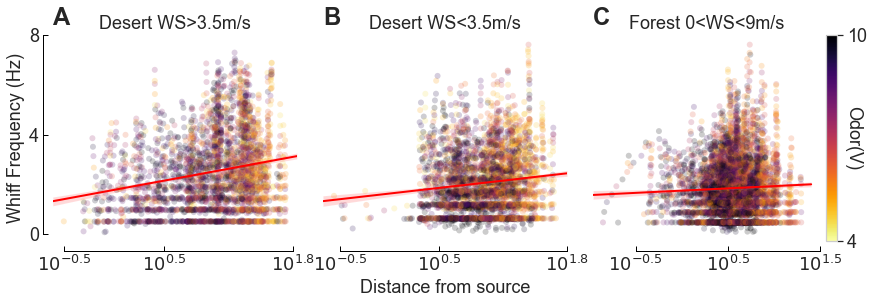

In [24]:
f, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(12,4))
                    

var1 = ax1.scatter(fdf_windy.log_avg_dist_from_source,fdf_windy.mean_ef,
                   c=fdf_windy.mean_concentration,cmap='inferno_r', 
                   edgecolors='none', alpha=0.2, vmin=4, vmax=10)
ax1.grid(False)

g1 = sns.regplot(x="log_avg_dist_from_source",y="mean_ef", data=fdf_windy, 
            ax=ax1, line_kws={'color':'red','linewidth':2}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)

mpl_functions.adjust_spines(ax1,['left','bottom'],
                            spine_locations={}, 
                            smart_bounds=True,
                            xticks=[-0.5,0.5,1.8],
                            yticks=[0,4,8],
                            linewidth=1)
ax1.set_xticklabels([r'$10^{-0.5}$',r'$10^{0.5}$',r'$10^{1.8}$'])

##########
var2 = ax2.scatter(fdf_notwindy.log_avg_dist_from_source,fdf_notwindy.mean_ef,
                    c=fdf_notwindy.mean_concentration,cmap='inferno_r', 
                    edgecolors='none', alpha=0.2, vmin=4, vmax=10)
ax2.grid(False)
g2 = sns.regplot(x="log_avg_dist_from_source",y="mean_ef", data=fdf_notwindy, 
            ax=ax2, line_kws={'color':'red','linewidth':2}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)
ax2.set_yticklabels("")
mpl_functions.adjust_spines(ax2,['bottom'],
                            spine_locations={}, 
                            smart_bounds=True,
                            xticks=[-0.5,0.5,1.8],
#                             yticks=[0,4500],
                            linewidth=1)
# ax2.yaxis.set_label_coords(-0.23, 0.5)
ax2.set_xticklabels([r'$10^{-0.5}$',r'$10^{0.5}$',r'$10^{1.8}$'])

##########


var3 = ax3.scatter(fdf_forest.log_avg_dist_from_source,fdf_forest.mean_ef,
                   c=fdf_forest.mean_concentration,cmap='inferno_r', 
                   edgecolors='none', alpha=0.2, vmin=4, vmax=10)
ax3.grid(False)
g3 = sns.regplot(x="log_avg_dist_from_source",y="mean_ef", data=fdf_forest, 
            ax=ax3, line_kws={'color':'red','linewidth':2}, scatter=False, truncate=False)
g3.set(xlabel=None, ylabel=None)
ax3.set_yticklabels("")

mpl_functions.adjust_spines(ax3,['bottom'],
                            spine_locations={}, 
                            smart_bounds=True,
                            xticks=[-0.5,0.5,1.5],
#                             yticks=[0,8],
                            linewidth=1)
ax3.set_xticklabels([r'$10^{-0.5}$', r'$10^{0.5}$',r'$10^{1.5}$'])

divider = make_axes_locatable(ax3)
cax3 = divider.append_axes('right', size='5%', pad=0.08)
cbar3=f.colorbar(var3, cax=cax3, orientation = 'vertical', ticks=[4, 10])
cbar3.ax.set_yticklabels(['4', '10'])
cbar3.solids.set(alpha=1)
cbar3.ax.set_ylabel('Odor(V)', rotation=-90, labelpad=-5)

ax1.set_ylabel('Whiff Frequency (Hz)')
ax2.set_xlabel('Distance from source')
ax1.set_title('Desert WS>3.5m/s')
ax2.set_title('Desert WS<3.5m/s')
ax3.set_title('Forest 0<WS<9m/s')

ax=[ax1,ax2,ax3]

f.tight_layout(pad=1)
figurefirst.mpl_functions.set_fontsize(f, 18)
for i in range(len(ax)):
    ax[i].text(0, 1.05, string.ascii_uppercase[i], transform=ax[i].transAxes, weight='bold', fontsize=24)

f.savefig('../../Figure/WF.jpeg', dpi=300, bbox_inches = "tight")

In [12]:

remove_motion_effect(fdf_windy)
remove_motion_effect(fdf_notwindy)
remove_motion_effect(fdf_forest)

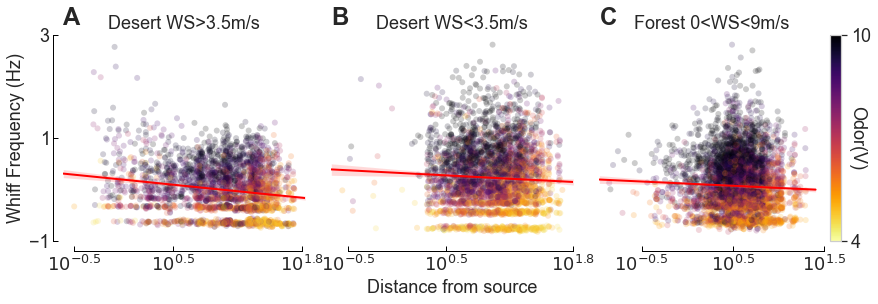

In [23]:
f, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(12,4))
                    

var1 = ax1.scatter(fdf_windy.log_avg_dist_from_source,fdf_windy.mean_ef_resid,
                   c=fdf_windy.mean_concentration,cmap='inferno_r', 
                   edgecolors='none', alpha=0.2, vmin=4, vmax=10)
ax1.grid(False)

g1 = sns.regplot(x="log_avg_dist_from_source",y="mean_ef_resid", data=fdf_windy, 
            ax=ax1, line_kws={'color':'red','linewidth':2}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)

mpl_functions.adjust_spines(ax1,['left','bottom'],
                            spine_locations={}, 
                            smart_bounds=True,
                            xticks=[-0.5,0.5,1.8],
                            yticks=[-1,1,3],
                            linewidth=1)
ax1.set_xticklabels([r'$10^{-0.5}$',r'$10^{0.5}$',r'$10^{1.8}$'])

##########
var2 = ax2.scatter(fdf_notwindy.log_avg_dist_from_source,fdf_notwindy.mean_ef_resid,
                    c=fdf_notwindy.mean_concentration,cmap='inferno_r', 
                    edgecolors='none', alpha=0.2, vmin=4, vmax=10)
ax2.grid(False)
g2 = sns.regplot(x="log_avg_dist_from_source",y="mean_ef_resid", data=fdf_notwindy, 
            ax=ax2, line_kws={'color':'red','linewidth':2}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)
ax2.set_yticklabels("")
mpl_functions.adjust_spines(ax2,['bottom'],
                            spine_locations={}, 
                            smart_bounds=True,
                            xticks=[-0.5,0.5,1.8],
#                             yticks=[0,4500],
                            linewidth=1)
# ax2.yaxis.set_label_coords(-0.23, 0.5)
ax2.set_xticklabels([r'$10^{-0.5}$',r'$10^{0.5}$',r'$10^{1.8}$'])

##########


var3 = ax3.scatter(fdf_forest.log_avg_dist_from_source,fdf_forest.mean_ef_resid,
                   c=fdf_forest.mean_concentration,cmap='inferno_r', 
                   edgecolors='none', alpha=0.2, vmin=4, vmax=10)
ax3.grid(False)
g3 = sns.regplot(x="log_avg_dist_from_source",y="mean_ef_resid", data=fdf_forest, 
            ax=ax3, line_kws={'color':'red','linewidth':2}, scatter=False, truncate=False)
g3.set(xlabel=None, ylabel=None)
ax3.set_yticklabels("")

mpl_functions.adjust_spines(ax3,['bottom'],
                            spine_locations={}, 
                            smart_bounds=True,
                            xticks=[-0.5,0.5,1.5],
                            yticks=[-1,3],
                            linewidth=1)
ax3.set_xticklabels([r'$10^{-0.5}$', r'$10^{0.5}$',r'$10^{1.5}$'])

divider = make_axes_locatable(ax3)
cax3 = divider.append_axes('right', size='5%', pad=0.08)
cbar3=f.colorbar(var3, cax=cax3, orientation = 'vertical', ticks=[4, 10])
cbar3.ax.set_yticklabels(['4', '10'])
cbar3.solids.set(alpha=1)
cbar3.ax.set_ylabel('Odor(V)', rotation=-90, labelpad=-5)

ax1.set_ylabel('Whiff Frequency (Hz)')
ax2.set_xlabel('Distance from source')
ax1.set_title('Desert WS>3.5m/s')
ax2.set_title('Desert WS<3.5m/s')
ax3.set_title('Forest 0<WS<9m/s')

ax=[ax1,ax2,ax3]

f.tight_layout(pad=1)
figurefirst.mpl_functions.set_fontsize(f, 18)
for i in range(len(ax)):
    ax[i].text(0, 1.05, string.ascii_uppercase[i], transform=ax[i].transAxes, weight='bold', fontsize=24)

f.savefig('../../Figure/WFRes.jpeg', dpi=300, bbox_inches = "tight")

<AxesSubplot:xlabel='mean_ef_resid', ylabel='Density'>

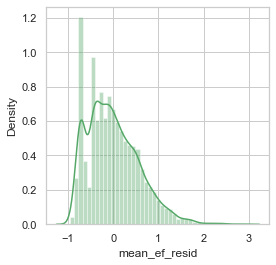

In [109]:
f,ax=plt.subplots(1,1,figsize=(4,4))
sns.distplot(fdf_forest.mean_ef_resid, color='g', ax=ax, label='residual')

In [ ]:
# f,ax=plt.subplots(2,2,figsize=(8,8))
# dataframe=fdf_forest
# ax[0][0].scatter(dataframe.avg_perpendicular_encounter.iloc[a],dataframe.mean_ef_resid.iloc[a],
#                  c=dataframe.avg_dist_from_source.iloc[a],cmap='inferno_r')
# var1=ax[0][1].scatter(dataframe.avg_perpendicular_encounter.iloc[a_],dataframe.mean_ef_resid.iloc[a_],
#                  c=dataframe.avg_dist_from_source.iloc[a_],cmap='inferno_r')

# divider = make_axes_locatable(ax[0][1])
# cax = divider.append_axes('right', size='5%', pad=0.08)
# cbar=f.colorbar(var1, cax=cax, orientation = 'vertical', ticks=[5,50])
# cbar.solids.set(alpha=1)
# # cbar.ax.set_yticklabels(['-33', '12'])
# cbar.ax.set_ylabel('Distance From source', rotation=-90, labelpad=2)

# ax[0][0].set_xlabel('Perpendicular Component +ve')
# ax[0][0].set_ylabel('Whiff Frequency +ve')
# ax[0][1].set_xlabel('Perpendicular Component -ve')
# ax[1][0].scatter(dataframe.avg_parallel_encounter.iloc[b],dataframe.mean_ef_resid.iloc[b],
#                 c=dataframe.avg_dist_from_source.iloc[b],cmap='inferno_r')
# ax[1][1].scatter(dataframe.avg_parallel_encounter.iloc[b_],dataframe.mean_ef_resid.iloc[b_],
#                 c=dataframe.avg_dist_from_source.iloc[b_])
# ax[1][0].set_xlabel('Parallel Component +ve')
# ax[1][1].set_xlabel('Parallel Component -ve')

# for i in range(0,2):
#     for j in range(0,2):
#         ax[i][j].grid(False)

# f.tight_layout(pad=1)
# figurefirst.mpl_functions.set_fontsize(f, 16)
# f.savefig('../../Figure/PP_f.jpeg', dpi=300, bbox_inches = "tight")


